# Data Pre-Processing, Tuning, and Modeling

Import libraries

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

Import cleaned data and exported from **Data Cleanup & EDA** jupyter notebook

In [3]:
train = pd.read_csv('datasets/cleaned_train.csv', keep_default_na=False, na_values=[''])
test = pd.read_csv('datasets/cleaned_test.csv', keep_default_na=False, na_values=[''])

In [4]:
test.isnull().sum().sort_values(ascending=False)

Lot Frontage     160
Garage Yr Blt     45
Garage Finish      1
Electrical         1
Sale Type          0
                ... 
Bedroom AbvGr      0
Kitchen AbvGr      0
Kitchen Qual       0
TotRms AbvGrd      0
Id                 0
Length: 80, dtype: int64

Clean data to fill in missing values and subset major outliers

### Linear Regression Model Functions 
Create custom functions to facilitate linear model testing

In [5]:
#function to get dummified column names based on original column name
def get_dummy_cols(df, ord_vars):
    dummy_cols = []
    data = pd.get_dummies(df, columns = ord_vars, drop_first=True)
    col_names = list(data.columns)
    for var in ord_vars:
        dummies = [col for col in col_names if var +"_" in col]
        dummy_cols += dummies
    return dummy_cols


#function to preform linear regression
def get_lr_scores(df, num_vars, ord_vars):
    lr = LinearRegression()
    if ord_vars == None:
        X = df[num_vars]
        y = df['SalePrice']
        var_list = None
    else:
        dummy_vars = get_dummy_cols(df,ord_vars)
        var_list =  ', '.join(ord_vars)
        data = pd.get_dummies(df, columns = ord_vars, drop_first=True)
        x_vars = num_vars + dummy_vars
        X = data[x_vars]
        y = data['SalePrice']
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
    lr.fit(X_train,y_train)
    train_score = lr.score(X_train,y_train)
    test_score = lr.score(X_test,y_test)
    y_preds = lr.predict(X_test)
    r2 = metrics.r2_score(y_test, y_preds)
    rmse = metrics.mean_squared_error(y_test, y_preds, squared = False)
    results = {'Num Vars': [', '.join(num_vars)],
               'Dummy Vars':[var_list],
               'Train': [train_score],
               'Test' : [test_score],
               'RMSE': [rmse]}
    return pd.DataFrame(results)
    
#function to return y preds from linear regression model
def get_lr_preds(df, df_test, num_vars, ord_vars):
    lr = LinearRegression()
    if ord_vars == None:
        X_train = df[num_vars]
        y_train = df['SalePrice']
        X_test = df_test[num_vars]
    else:
        dummy_vars = get_dummy_cols(df,ord_vars)
        test_dummy_vars = get_dummy_cols(test, ord_vars)
        data = pd.get_dummies(df, columns = ord_vars, drop_first=True)
        data_test = pd.get_dummies(df_test, columns = ord_vars, drop_first=True)
        x_vars = num_vars + dummy_vars
        X_train = data[x_vars]
        y_train = data['SalePrice']
        #see if test df dummy cols match train df dummy cols
        cols_to_drop = [col for col in test_dummy_vars if col not in dummy_vars]
        cols_to_add = [col for col in dummy_vars if col not in test_dummy_vars]
        #adjust columns in test df dummy to match 
        data_test.drop(columns=cols_to_drop, inplace=True)
        for col in cols_to_add:
              data_test[col] = 0
        X_test = data_test[x_vars]
    lr.fit(X_train,y_train)
    train_score = lr.score(X_train,y_train)
    y_preds = lr.predict(X_test)
    return y_preds

def get_lr_resids(df, num_vars, ord_vars):
    lr = LinearRegression()
    if ord_vars == None:
        X = df[num_vars]
        y = df['SalePrice']
        var_list = None
    else:
        dummy_vars = get_dummy_cols(df,ord_vars)
        var_list =  ', '.join(ord_vars)
        data = pd.get_dummies(df, columns = ord_vars, drop_first=True)
        x_vars = num_vars + dummy_vars
        X = data[x_vars]
        y = data['SalePrice']
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
    lr.fit(X_train,y_train)
    train_score = lr.score(X_train,y_train)
    test_score = lr.score(X_test,y_test)
    y_preds = lr.predict(X_test)
    resids = y_test - y_preds
    return  resids

def get_lr_test_preds(df, num_vars, ord_vars):
    lr = LinearRegression()
    if ord_vars == None:
        X = df[num_vars]
        y = df['SalePrice']
        var_list = None
    else:
        dummy_vars = get_dummy_cols(df,ord_vars)
        var_list =  ', '.join(ord_vars)
        data = pd.get_dummies(df, columns = ord_vars, drop_first=True)
        x_vars = num_vars + dummy_vars
        X = data[x_vars]
        y = data['SalePrice']
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
    lr.fit(X_train,y_train)
    train_score = lr.score(X_train,y_train)
    test_score = lr.score(X_test,y_test)
    y_preds = lr.predict(X_test)
    return  y_preds

## Collect results and scores we try different models

In [6]:
result_scores = []
results = test

Subset training data to remove major outliers with Above Ground Area.

In [7]:
train_sub = train[train['Gr Liv Area']<4000]

## Linear Models

### 1. Linear Model - Testing with only numeric values

In [8]:
nums1 =     ['Year Built'
            ,'Year Remod/Add'
            ,'Gr Liv Area'
            ,'Garage Area'
            ,'Overall Qual'
            ,'Overall Cond'
            ,'Total Bsmt SF']

preds1 = get_lr_preds(train_sub, test, nums1, None)
results['Preds1'] = preds1

rs1 = get_lr_scores(train_sub, nums1, None)
rs1['Desc'] = '1 - LR Numeric Only'
result_scores.append(rs1)
rs1

,Num Vars,Dummy Vars,Train,Test,RMSE,Desc
0,"Year Built, Year Remod/Add, Gr Liv Area, Garag...",None,0.825776,0.842375,31567.738063,1 - LR Numeric Only


Text(0.5, 1.0, 'Linear Model (No Dummy Vars): Predicted Value vs. Residual')

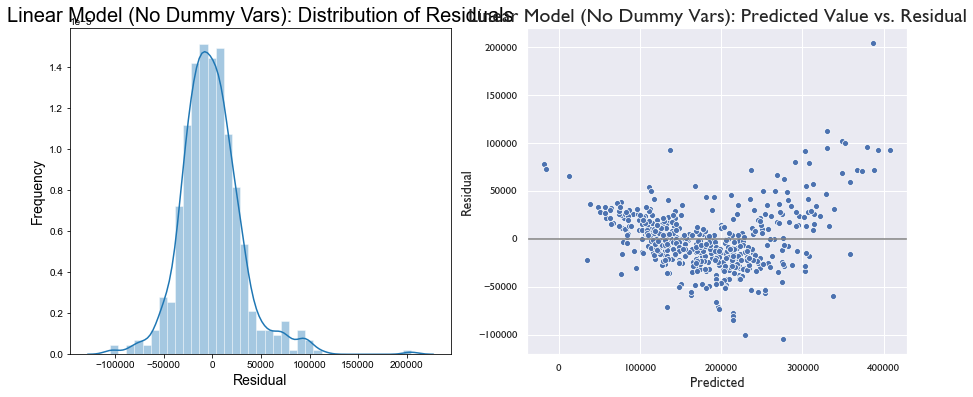

In [9]:
resids = get_lr_resids(train_sub, nums1, None)
y_preds = get_lr_test_preds(train_sub, nums1, None)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.set_style("darkgrid")
sns.set(font= "Gill Sans")

hist = sns.distplot(resids)
hist.set_title("Linear Model (No Dummy Vars): Distribution of Residuals", fontsize = 20)
hist.set_xlabel("Residual", fontsize = 14)
hist.set_ylabel("Frequency", fontsize = 14)

plt.subplot(1,2,2)
p = sns.scatterplot(x=y_preds, y=resids)
p.axhline(0,color="grey")
p.set_xlabel("Predicted", fontsize = 14)
p.set_ylabel("Residual", fontsize = 14)
p.set_title("Linear Model (No Dummy Vars): Predicted Value vs. Residual", fontsize = 20)

#plt.savefig("images/Model1_LR_NoDummy.png", dpi=300)

### 2. Linear Model - Testing with only numeric and dummy values

In [10]:
nums2 =     ['Year Built'
            ,'Year Remod/Add'
            ,'Gr Liv Area'
            ,'Garage Area'
            ,'Overall Qual'
            ,'Overall Cond'
            ,'Total Bsmt SF']

ords2 =     ['MS Zoning'
            ,'Foundation'
            ,'Neighborhood'
            ,'Bsmt Qual'
            ,'Mas Vnr Type'
            ,'Kitchen Qual'
            ,'Garage Qual'
            ,'Lot Shape'
            ,'Heating QC'
            ,'Exter Qual'
           ]

preds2 = get_lr_preds(train_sub, test, nums2, ords2)
results['Preds2'] = preds2

rs2 = get_lr_scores(train_sub, nums2, ords2)
rs2['Desc'] = '2 - LR Numeric & Categorical Var'
result_scores.append(rs2)
rs2

,Num Vars,Dummy Vars,Train,Test,RMSE,Desc
0,"Year Built, Year Remod/Add, Gr Liv Area, Garag...","MS Zoning, Foundation, Neighborhood, Bsmt Qual...",0.89688,0.901467,24958.732002,2 - LR Numeric & Categorical Var


Text(0.5, 1.0, 'Linear Model (OQ as Num): Predicted Value vs. Residual')

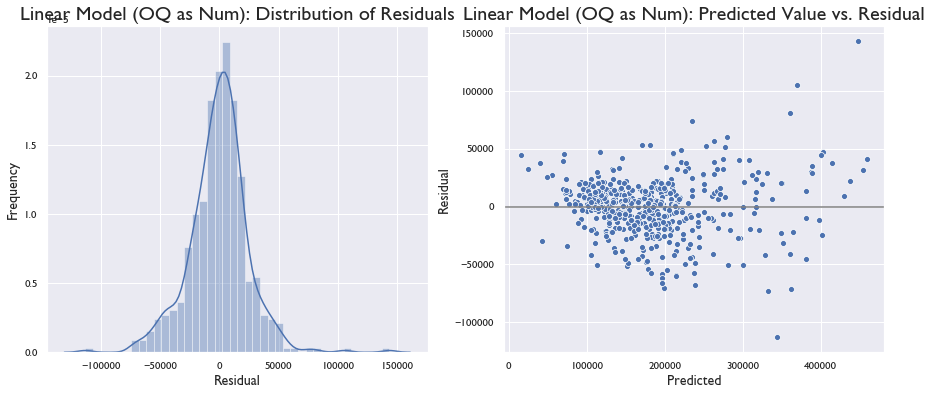

In [11]:
resids = get_lr_resids(train_sub, nums2, ords2)
y_preds = get_lr_test_preds(train_sub, nums2, ords2)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.set_style("darkgrid")
sns.set(font= "Gill Sans")

hist = sns.distplot(resids)
hist.set_title("Linear Model (OQ as Num): Distribution of Residuals", fontsize = 20)
hist.set_xlabel("Residual", fontsize = 14)
hist.set_ylabel("Frequency", fontsize = 14)

plt.subplot(1,2,2)
p = sns.scatterplot(x=y_preds, y=resids)
p.axhline(0,color="grey")
p.set_xlabel("Predicted", fontsize = 14)
p.set_ylabel("Residual", fontsize = 14)
p.set_title("Linear Model (OQ as Num): Predicted Value vs. Residual", fontsize = 20)

#plt.savefig("images/Model2_LR_WithDummy.png", dpi=300)

### 3. Linear Model - Changing Overall Quality to Categorical Dummy instead of Numerical Value

In [12]:
nums3 =     ['Year Built'
            ,'Year Remod/Add'
            ,'Gr Liv Area'
            ,'Garage Area'
            ,'Overall Cond'
            ,'Total Bsmt SF']

ords3 =     ['MS Zoning'
            ,'Foundation'
            ,'Neighborhood'
            ,'Bsmt Qual'
            ,'Mas Vnr Type'
            ,'Kitchen Qual'
            ,'Overall Qual'
            ,'Garage Qual'
            ,'Lot Shape'
            ,'Heating QC'
            ,'Exter Qual'
           ]

preds3 = get_lr_preds(train_sub, test, nums3, ords3)
results['Preds3'] = preds3

rs3 = get_lr_scores(train_sub, nums3, ords3)
rs3['Desc'] = '3 - LR Overall Qual as Dummy'
result_scores.append(rs3)
rs3

,Num Vars,Dummy Vars,Train,Test,RMSE,Desc
0,"Year Built, Year Remod/Add, Gr Liv Area, Garag...","MS Zoning, Foundation, Neighborhood, Bsmt Qual...",0.903489,0.906133,24360.523055,3 - LR Overall Qual as Dummy


Text(0.5, 1.0, 'Linear Model (OQ as Dummy): Predicted Value vs. Residual')

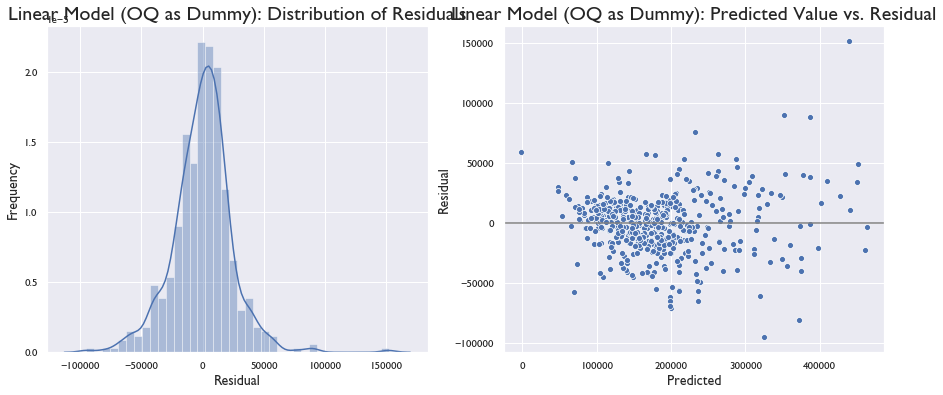

In [13]:
resids = get_lr_resids(train_sub, nums3, ords3)
y_preds = get_lr_test_preds(train_sub, nums3, ords3)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.set_style("darkgrid")
sns.set(font= "Gill Sans")

hist = sns.distplot(resids)
hist.set_title("Linear Model (OQ as Dummy): Distribution of Residuals", fontsize = 20)
hist.set_xlabel("Residual", fontsize = 14)
hist.set_ylabel("Frequency", fontsize = 14)

plt.subplot(1,2,2)
p = sns.scatterplot(x=y_preds, y=resids)
p.axhline(0,color="grey")
p.set_xlabel("Predicted", fontsize = 14)
p.set_ylabel("Residual", fontsize = 14)
p.set_title("Linear Model (OQ as Dummy): Predicted Value vs. Residual", fontsize = 20)

#plt.savefig("images/Model3_LR_WithOQDummy.png", dpi=300)

### 4. Linear Model - Using original Train Data with Sqft Outliers

In [14]:
preds4 = get_lr_preds(train, test, nums3, ords3)
results['Preds4'] = preds4

rs4 = get_lr_scores(train, nums3, ords3)
rs4['Desc'] = '4 - LR Overall Qual Dummy & Sqft Outliers'
result_scores.append(rs4)
rs4

,Num Vars,Dummy Vars,Train,Test,RMSE,Desc
0,"Year Built, Year Remod/Add, Gr Liv Area, Garag...","MS Zoning, Foundation, Neighborhood, Bsmt Qual...",0.865416,0.882308,26881.853463,4 - LR Overall Qual Dummy & Sqft Outliers


## Ridge & Lasso Models
Testing and Lasso models with the use of Pipeline (easier to scale data in one step).

In [15]:
#usee same features as best linear model outcome
nums =     ['Year Built'
            ,'Year Remod/Add'
            ,'Gr Liv Area'
            ,'Garage Area'
            ,'Overall Cond'
            ,'Total Bsmt SF']

ords =     ['MS Zoning'
            ,'Foundation'
            ,'Neighborhood'
            ,'Bsmt Qual'
            ,'Mas Vnr Type'
            ,'Kitchen Qual'
            ,'Overall Qual'
            ,'Garage Qual'
            ,'Lot Shape'
            ,'Heating QC'
            ,'Exter Qual'
           ]

**Formatting Data** - Create dummy variables for both datasets, standardize columns (e.g. Neighborhood missing in test, add with "0" value. If value exists in test and not in train, drop from test data set.

In [16]:
dummy_vars = get_dummy_cols(train_sub,ords)
data = pd.get_dummies(train_sub, columns = ords, drop_first=True)
x_vars = nums + dummy_vars
X = data[x_vars]
y = data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [17]:
test_dummy_vars = get_dummy_cols(test, ords)
data_test = pd.get_dummies(test, columns = ords, drop_first=True)

#see if test df dummy cols match train df dummy cols
cols_to_drop = [col for col in test_dummy_vars if col not in dummy_vars]
cols_to_add = [col for col in dummy_vars if col not in test_dummy_vars]

#adjust columns in test df dummy to match 
data_test.drop(columns=cols_to_drop, inplace=True)
for col in cols_to_add:
      data_test[col] = 0
X_test_actual = data_test[x_vars]

### 5. Ridge Model - Use Pipeline & Ridge

In [18]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('ridge', Ridge())
])

pipe.fit(X_train,y_train)
train_score = pipe.score(X_train,y_train)
test_score = pipe.score(X_test,y_test)

y_preds = pipe.predict(X_test)
rmse = metrics.mean_squared_error(y_test, y_preds, squared = False)

results['Preds5'] = pipe.predict(X_test_actual)
resids = y_test - y_preds

rs5 = {'Num Vars':[', '.join(nums)], 
'Dummy Vars':[', '.join(ords)], 
'Train':[ train_score],
'Test': [test_score],
'RMSE': [rmse],
'Desc': ["5 - Ridge"]}

rs5 = pd.DataFrame(rs5)
result_scores.append(rs5)
rs5

,Num Vars,Dummy Vars,Train,Test,RMSE,Desc
0,"Year Built, Year Remod/Add, Gr Liv Area, Garag...","MS Zoning, Foundation, Neighborhood, Bsmt Qual...",0.903456,0.906794,24274.594193,5 - Ridge


Text(0.5, 1.0, 'Ridge: Predicted Value vs. Residual')

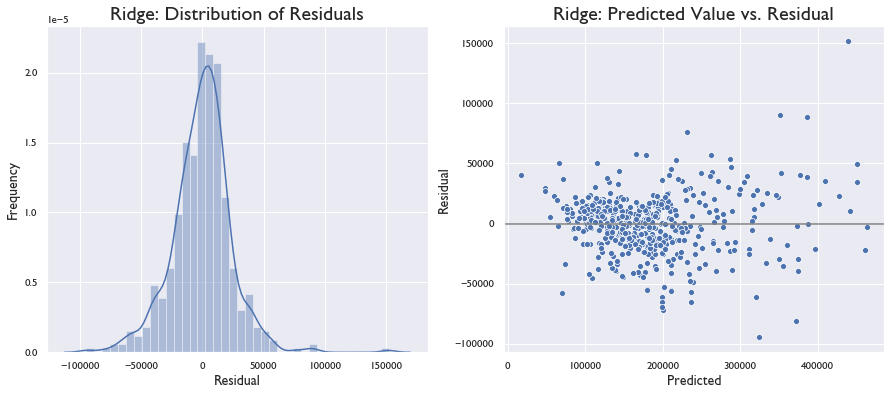

In [19]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.set_style("darkgrid")
sns.set(font= "Gill Sans")

hist = sns.distplot(resids)
hist.set_title("Ridge: Distribution of Residuals", fontsize = 20)
hist.set_xlabel("Residual", fontsize = 14)
hist.set_ylabel("Frequency", fontsize = 14)

plt.subplot(1,2,2)
p = sns.scatterplot(x=y_preds, y=resids)
p.axhline(0,color="grey")
p.set_xlabel("Predicted", fontsize = 14)
p.set_ylabel("Residual", fontsize = 14)
p.set_title("Ridge: Predicted Value vs. Residual", fontsize = 20)

#plt.savefig("images/Model5_Ridge.png", dpi=300)

### 6. LassoCV Model - Use Pipeline & LassoCV

In [20]:
pipe_lasso = Pipeline([
    ('ss', StandardScaler()),
    ('lasso', LassoCV())
])

pipe_lasso.fit(X_train,y_train)
train_score = pipe_lasso.score(X_train,y_train)
test_score = pipe_lasso.score(X_test,y_test)

y_preds = pipe_lasso.predict(X_test)
rmse = metrics.mean_squared_error(y_test, y_preds, squared = False)

results['Preds6'] = pipe_lasso.predict(X_test_actual)
resids = y_test - y_preds

rs6 = {'Num Vars':[', '.join(nums)], 
'Dummy Vars':[', '.join(ords)], 
'Train':[ train_score],
'Test': [test_score],
'RMSE': [rmse],
'Desc': ["6 - LassoCV"]}

rs6 = pd.DataFrame(rs6)
result_scores.append(rs6)
rs6


,Num Vars,Dummy Vars,Train,Test,RMSE,Desc
0,"Year Built, Year Remod/Add, Gr Liv Area, Garag...","MS Zoning, Foundation, Neighborhood, Bsmt Qual...",0.902568,0.907767,24147.594608,6 - LassoCV


Text(0.5, 1.0, 'LassoCV: Predicted Value vs. Residual')

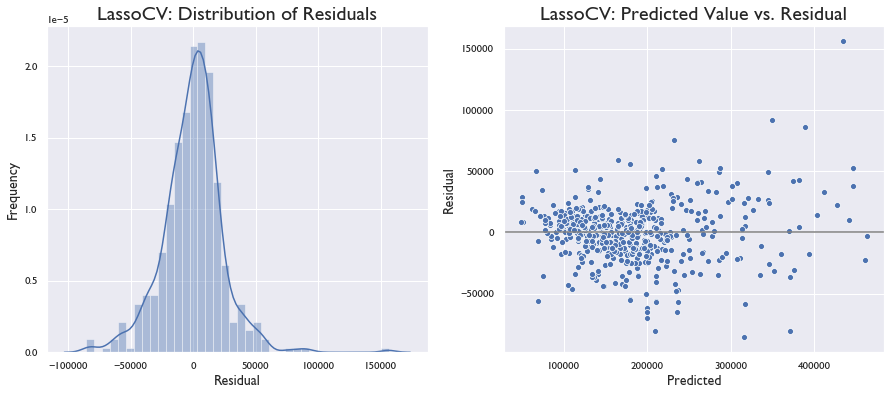

In [21]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.set_style("darkgrid")
sns.set(font= "Gill Sans")

hist = sns.distplot(resids)
hist.set_title("LassoCV: Distribution of Residuals", fontsize = 20)
hist.set_xlabel("Residual", fontsize = 14)
hist.set_ylabel("Frequency", fontsize = 14)

plt.subplot(1,2,2)
p = sns.scatterplot(x=y_preds, y=resids)
p.axhline(0,color="grey")
p.set_xlabel("Predicted", fontsize = 14)
p.set_ylabel("Residual", fontsize = 14)
p.set_title("LassoCV: Predicted Value vs. Residual", fontsize = 20)

#plt.savefig("images/Model6_LassoCV.png", dpi=300)

### Testing GridSearch to adjust Model Parameters

In [22]:
pipe2 = Pipeline([
    ('ss', StandardScaler()),
    ('model', Ridge())
])

pipe_params = {
    'model__alpha': range(0,100)
}

In [23]:
pipe2_gridsearch = GridSearchCV(
                              pipe2, # What is the model we want to fit?
                              pipe_params, # What is the dictionary of hyperparameters?
                              cv=5, # What number of folds in CV will we use?
                              verbose=1)

In [24]:
pipe2_gridsearch.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    6.2s finished


In [25]:
pipe2_gridsearch.best_score_

0.8852218868118641

In [26]:
pipe2_gridsearch.best_estimator_

Pipeline(steps=[('ss', StandardScaler()), ('model', Ridge(alpha=26))])

### 7. Ridge Model - Use Ridge with Alpha adjusted based on GridSearch

In [27]:
pipe3 = Pipeline([
    ('ss', StandardScaler()),
    ('ridge', Ridge(alpha=26))
])

pipe3.fit(X_train,y_train)
train_score = pipe3.score(X_train,y_train)
test_score = pipe3.score(X_test,y_test)

y_preds = pipe3.predict(X_test)
rmse = metrics.mean_squared_error(y_test, y_preds, squared = False)

results['Preds7'] = pipe3.predict(X_test_actual)

rs7 = {'Num Vars':[', '.join(nums)], 
'Dummy Vars':[', '.join(ords)], 
'Train':[ train_score],
'Test': [test_score],
'RMSE': [rmse],
'Desc': ["7 - Ridge Alpha 26"]}


rs7 = pd.DataFrame(rs7)
result_scores.append(rs7)
rs7

,Num Vars,Dummy Vars,Train,Test,RMSE,Desc
0,"Year Built, Year Remod/Add, Gr Liv Area, Garag...","MS Zoning, Foundation, Neighborhood, Bsmt Qual...",0.902805,0.907912,24128.636789,7 - Ridge Alpha 26


In [28]:
results = results[['Id','Preds1','Preds2','Preds3','Preds4','Preds5','Preds6','Preds7']]

In [29]:
results.to_csv("datasets/kaggle_predictions.csv",index=False)

In [30]:
results

,Id,Preds1,Preds2,Preds3,Preds4,Preds5,Preds6,Preds7
0,2658,185126.608181,157506.232027,159877.664981,150094.685030,170240.860292,165580.127062,165917.823429
1,2718,227151.309068,212118.342281,209723.292877,188407.911021,210438.167854,209345.570444,208651.641133
2,2414,190281.414185,181661.037791,180977.364578,186248.611170,182634.871988,181971.384608,182712.242423
3,1989,118926.544029,146494.533159,127687.655395,141502.052679,125880.999305,100797.127129,111365.575346
4,625,180805.863433,173146.396529,169589.936922,165544.920462,168812.996700,167626.107847,168393.321208
...,...,...,...,...,...,...,...,...
873,1662,204462.293363,179857.671774,180790.060462,181020.321301,180618.107849,181952.720899,180644.347737
874,1234,218081.063504,208177.211107,207708.462018,204053.880265,208215.628777,207755.537035,207754.260844
875,1373,127834.130957,130638.623606,130312.064863,130388.654171,130919.434488,130142.047539,130643.779509
876,1672,104473.956403,112437.174432,120433.905663,122204.251794,120417.202661,120699.945384,120845.431086


In [31]:
model_scores = pd.concat(result_scores)

In [32]:
model_scores.to_csv("datasets/model_scores.csv",index=False)